# Psychophysics - Analyse des données

On va faire une regression logistique des données obtenues en psychophysiques, pour chercher le seuil B_theta vers lequel les gens perdent en performances. On le comparera ensuite qualitativement au performances du modèle pour essayer de valider sa plausibilité neurobiologique. 

In [1]:
%ls ./psychophysics_data/Psy_discrim_final*.p

 ./psychophysics_data/Psy_discrim_final_ACT.p
 ./psychophysics_data/Psy_discrim_final_AM.p
 ./psychophysics_data/Psy_discrim_final_BB.p
 ./psychophysics_data/Psy_discrim_final_convo_model_HIRES.p
 ./psychophysics_data/Psy_discrim_final_DL.p
 ./psychophysics_data/Psy_discrim_final_FM.p
 ./psychophysics_data/Psy_discrim_final_HL.p
 ./psychophysics_data/Psy_discrim_final_KB.p
 ./psychophysics_data/Psy_discrim_final_LP.p
 ./psychophysics_data/Psy_discrim_final_MAP.p
 ./psychophysics_data/Psy_discrim_final_MB.p
'./psychophysics_data/Psy_discrim_final_Model - Convo.p'
 ./psychophysics_data/Psy_discrim_final_model_ring_HIRES.p
'./psychophysics_data/Psy_discrim_final_Model - Ring.p'
 ./psychophysics_data/Psy_discrim_final_model_weird_freezing_data.p
 ./psychophysics_data/Psy_discrim_final_MP.p
 ./psychophysics_data/Psy_discrim_final_NP.p
 ./psychophysics_data/Psy_discrim_final_PA.p


En utilisant le modèle de régression logistique de scikit-learn, on fait un modèle pour chaque sujet :

# Tache de discrimination 

In [2]:
import pickle
import matplotlib.pyplot as plt

subj_name_list =  ['Model - Ring']
#['ACT', 'AM', 'BB', 'DL', 'FM', 'HL','KB', 'LP', 'MAP', 'MB', 'MP', 'NP', 'PA']
                  #'Model - Ring','Model - Convo']
                
subj_data_list = []

for subject in subj_name_list :
#   x = pickle.load(open('Psychophys_discrim_2018-06-06_%s.p'%subject, 'rb'))
    x = pickle.load(open('./psychophysics_data/Psy_discrim_final_%s.p'%subject, 'rb'))
    subj_data_list.append(x)

En sujet individuel et en utilisant tout les B_theta:

/home/hugo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hugo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


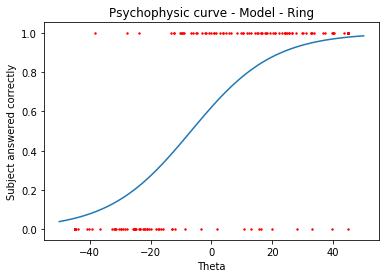

In [3]:
from sklearn.linear_model import LogisticRegression
import numpy as np

#the values used for plotting once the model is built
x_values = np.linspace(-50, 50, 100)
x_plot = np.reshape(x_values, (100,1))

for num, subj_data in enumerate(subj_data_list) :
    X = []
    for i in subj_data :
        #X.append(i[3]*180/np.pi)
        X.append(i[1]*180/np.pi)

    y =[]
    for i in subj_data :
        if False:
            # fitting if correct 
            if np.sign(i[1]) > 0 and i[2] == 'right':
                y.append(1)
            else :
                y.append(0)
            #y.append(i[1])
        else:
            # fitting with direction 
            if i[2] == 'right':
                y.append(1)
            else :
                y.append(0)
            #y.append(i[1])

    
    #reshaped for fitting
    X = np.asarray(X)
    X = X[:,np.newaxis]
    
    #logistic regression
    lgs = LogisticRegression(C = 3, max_iter = 100, penalty = 'l1' ,class_weight = {1 : 1 , 0 : 1}) 
    lgs.fit(X, y)
    #print(lgs.coef_)
    y_values = lgs.predict_proba(x_plot)[:,1]
    plt.plot(x_values, y_values, label = 'LogReg')

    plt.scatter(X, y, c='r', s=2)
    plt.title('Psychophysic curve - %s' % subj_name_list[num])
    plt.xlabel("Theta")
    plt.ylabel("Subject answered correctly")
    #plt.legend()
    plt.show()

En sujet individuel avec une courbe par B_theta :

In [4]:
b_thetas_list = []
for x in subj_data_list[0] :
    b_thetas_list.append(x[3]*180/np.pi)

b_thetas_list = sorted(set(b_thetas_list))
print(b_thetas_list)

[2.8125, 5.011305289539408, 8.929130917321123, 15.90990257669732, 28.34822362263465, 50.51079217392179, 90.0]


Courbe psychophysique - Sujet Model - Ring


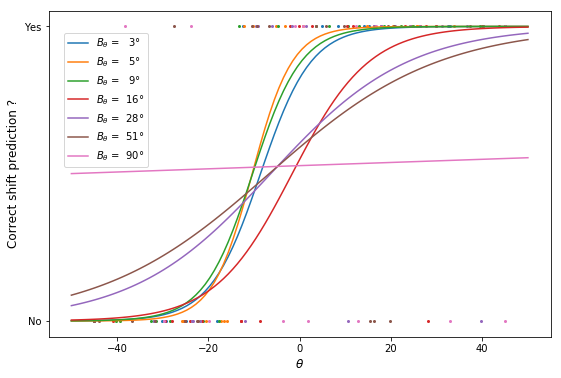

In [5]:
from sklearn.linear_model import LogisticRegression
import numpy as np

#the values used for plotting once the model is built
x_values = np.linspace(-50, 50, 100)
x_plot = np.reshape(x_values, (100,1))

lr_kwargs = dict(solver='liblinear', C = 3, max_iter=1000, penalty='l2', class_weight = {1 : 1 , 0 : 1})

coef_list = []

for num, subj_data in enumerate(subj_data_list) :
    plt.figure(figsize = (9,6))
    for ibtheta, b_theta in enumerate(b_thetas_list):
        X = []
        y =[]

        for i in subj_data :
            if i[3]*180/np.pi == b_theta :
                X.append(i[1]*180/np.pi)
                if False:
                    # fitting if correct 
                    if np.sign(i[1]) > 0 and i[2] == 'right':
                        y.append(1)
                    else :
                        y.append(0)
                    #y.append(i[1])
                else:
                    # fitting with direction 
                    if i[2] == 'right':
                        y.append(1)
                    else :
                        y.append(0)
                    #y.append(i[1])


        #reshaped for fitting
        X = np.asarray(X)
        X = X[:,np.newaxis]

        #logistic regression
        lgs = LogisticRegression(**lr_kwargs) 
        try :
            lgs.fit(X, y)
            coef_list.append((b_theta,lgs.coef_[0][0]))
        
            y_values = lgs.predict_proba(x_plot)[:,1]
            plt.plot(x_values, y_values, label = r'$B_\theta$ = %3.f°' %b_theta)
            plt.scatter(X, y, s=4)
        except :
            pass
        
        
    #plt.title('Courbe psychophysique - Sujet %s' % subj_name_list[num])
    print('Courbe psychophysique - Sujet %s' % subj_name_list[num])
    plt.yticks([0.,1.],['No', 'Yes'])
    plt.xlabel(r'$\theta$', fontsize = 12,)
    plt.ylabel("Correct shift prediction ?", fontsize = 12)
    plt.legend(loc = (0.03, 0.52)) #tuple of axis coordinate is also valid
    
    plt.savefig('./figs/Psychodiscri_curve_subj_%s.pdf' % subj_name_list[num],format='pdf', dpi=1000,
               bbox_inches = 'tight')
    
    plt.show()

# F1 Score

In [12]:
import pickle
import numpy as np
subj_name_list = ['AM', 'model_weird_freezing_data', 'model_ring_HIRES',
                 'ACT', 'BB', 'DL', 'FM', 'HL','KB', 'LP', 'MAP', 'MB', 'MP', 'NP', 'PA']
subj_data_list = []
for subject in subj_name_list :
#   x = pickle.load(open('Psychophys_discrim_2018-06-06_%s.p'%subject, 'rb'))
    x = pickle.load(open('./psychophysics_data/Psy_discrim_final_%s.p'%subject, 'rb'))
    subj_data_list.append(x)
    
b_thetas_list = []
for x in subj_data_list[0] :
    b_thetas_list.append(x[3]*180/np.pi)
b_thetas_list = sorted(set(b_thetas_list))

hires_b_thetas_list = []
for x in subj_data_list[1] :
    hires_b_thetas_list.append(x[3]*180/np.pi)
hires_b_thetas_list = sorted(set(hires_b_thetas_list))


In [59]:
import sklearn.metrics as metrics
import pickle
import matplotlib.pyplot as plt

#pas beau en subject average, il doit y avoir des outliers a eliminer
#subj_name_list =  ['ACT', 'AM', 'BB', 'DL', 'FM', 'HL','KB', 'LP', 'MAP', 'MB', 'MP', 'NP', 'PA']


def f1_score(subj_name_list, b_list):
    subj_data_list = []
    for subject in subj_name_list :
    #   x = pickle.load(open('Psychophys_discrim_2018-06-06_%s.p'%subject, 'rb'))
        x = pickle.load(open('./psychophysics_data/Psy_discrim_final_%s.p'%subject, 'rb'))
        subj_data_list.append(x)

    f1_list = []
    #Reminder, trials are in the form of [numtrial, shift angle, answered direction, b_theta]

    #for each b_theta, we loop through all the trials of each subject and we append trials whose b_theta
    #is the one we are currently selecting. We then compute f1 score and append it to a f1 list
    for b_theta in b_list :
        dir_list = []
        answered_list  = []
        for subj in subj_data_list :
            for trials in subj :
                if trials[3]*180/np.pi == b_theta :
                    if trials[2] == 'left' :
                        dir_list.append(0)
                    if trials[2] == 'right':
                        dir_list.append(1)

                    if np.sign(trials[1]) < 0 :
                        answered_list.append(0)
                    if np.sign(trials[1]) > 0 :
                        answered_list.append(1)
        f1_list.append(metrics.f1_score(dir_list, answered_list))
        
    return f1_list
        
hum_f1 = f1_score(['MAP'], b_thetas_list)
convo_f1 = f1_score(['model_weird_freezing_data'], hires_b_thetas_list)
rnn_f1 = f1_score(['model_ring_HIRES'], hires_b_thetas_list)

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit.models import LinearModel, RectangleModel,ExpressionModel
from lmfit import Parameters, Parameter

def log_fit(x, y):  # returns a rectangle logfit of the xy
    y = np.asarray(y)
    step_mod = RectangleModel(form='logistic', prefix='step_')
    line_mod = LinearModel(prefix='line_')
    parms = line_mod.make_params(intercept=y.min(), slope=0)
    parms += step_mod.guess(y, x=x, center=2.5)
    mod = step_mod  # + line_mod
    out = mod.fit(y, parms, x=x)
    return out.best_fit

In [61]:
def expr_fit(x, y, x50=45, n=2):  # returns an expression fitting of the x y
    mod = ExpressionModel('1 / (1 + (x/x50)**n) ')
    pars = mod.make_params(x50=x50, n=n)
    out = mod.fit(y, pars, x=x)
    return out.best_fit

In [62]:
def naka_rushton(x, y):  # returns an expression fitting of the x y
    mod = ExpressionModel('1 / ( 1 + (1 /x0**b) * x**b)')
    mod.nan_policy = 'propagate'
    pars = Parameters()
    pars['b'] = Parameter(name = 'b', value = 2, min = 0.01)
    pars['x0'] = Parameter(name = 'x0', value = .8)
    out = mod.fit(y, pars, x=x)
    return out.best_fit

In [63]:
def expr_fit(x, y):  # returns an expression fitting of the x y
    mod = ExpressionModel('1 / ( 1 -amp)  * .5 / (1 + (x/x50)**n) +.5')
    mod.nan_policy = 'propagate'
    pars = Parameters()
    pars['amp'] = Parameter(name = 'amp', value = .8, min = 0.01)
    pars['x50'] = Parameter(name = 'x50', value = 45 )
    pars['n'] = Parameter(name = 'n', value = 2, min = 0.01)
    
    out = mod.fit(y, pars, x=x)
    return out.best_fit

In [102]:
def mega_logistic(x, y):  # logistique quadratique, qui marche pas
    mod = ExpressionModel('d+ (a-d)/(1+(x/c)**b)')
    mod.nan_policy = 'propagate'
    pars = Parameters()
    pars['d'] = Parameter(name = 'ymax', value = .6, min = 0.01)
    pars['a'] = Parameter(name = 'ymin', value = .8, min = .01 )
    pars['b'] = Parameter(name = 'slope', value = 2)
    pars['c'] = Parameter(name = 'xinflection', value = 50, min = 0.01)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report())
    result = out.minimize()
    print(confidence.conf_interval(mod, result))
    return out.best_fit

#la version avec les params récupérés du report
def cheatplot_rnn(x):
    return 0.6207649 + (0.8338102 - 0.6207649)/(1 + (x/49.92666)**25.4327)

def cheatplot_AM(x):
    return 0.4285714 + (0.9541894 - 0.4285714)/(1 + (x/50.01598)**43.16771)

def cheatplot_BB(x):
    return 0.01000000 + (1.00201059 - 0.4285714)/(1 + (x/165.334424)**0.866527771)

def cheatplot_MAP(x):
    return 0.59964406 + (0.96402736 -0.59964406)/(1 + (x/43.0670946)**9.34793422)

def cheatplot_convo(x):
    return 0.4701946 + (0.7679601 - 0.4701946)/(1 + (x/40.80054)**1.664791)

xs = np.linspace(0,90, 100)
ys1, ys2, ys3, ys4 = [], [], [], []
for x1 in xs :
    ys1.append(cheatplot_rnn(x1))

for x2 in xs :
    ys2.append(cheatplot_MAP(x2))

for x3 in xs :
    ys3.append(cheatplot_convo(x3))

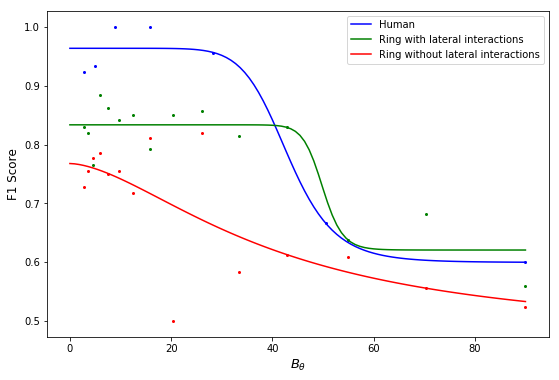

In [104]:
#plt.plot(b_thetas_list, f1_list)
plt.figure(figsize = (9,6))

#plt.plot(b_thetas_list, mega_logistic(b_thetas_list,hum_f1),color = 'orange', label = 'EXPER')
#plt.plot(hires_b_thetas_list, mega_logistic(hires_b_thetas_list,rnn_f1),color = 'green', label = 'Ring with lateral interactions')
#plt.plot(hires_b_thetas_list, mega_logistic(hires_b_thetas_list,convo_f1), color = 'red',label = 'Ring without lateral interactions')

size = 16
marker = '.'
plt.scatter(b_thetas_list, hum_f1, color = 'blue', s= size,marker =marker)
plt.plot(xs, ys2, color = 'blue', label = 'Human')

plt.scatter(hires_b_thetas_list, rnn_f1, color = 'green',  s = size,marker =marker)
plt.plot(xs, ys1, color = 'green', label = 'Ring with lateral interactions')

plt.scatter(hires_b_thetas_list, convo_f1, color = 'red',  s = size,marker =marker)
plt.plot(xs, ys3, color = 'red', label = 'Ring without lateral interactions')

'''plt.plot(b_thetas_list, hum_f1, color = 'blue')
plt.plot(hires_b_thetas_list, rnn_f1, color = 'green')
plt.plot(hires_b_thetas_list, convo_f1, color = 'red')'''


plt.xlabel(r'$B_\theta$', fontsize = 13)
plt.ylabel('F1 Score', fontsize = 12)
plt.legend()
#plt.title(r'Variation du F1 score en fonction de $B_\theta$')
plt.savefig('./figs/F1_curve.pdf',format='pdf', dpi=1000, bbox_inches = 'tight')
plt.show()

In [79]:
import lmfit.confidence as confidence

In [80]:
help(confidence)

Help on module lmfit.confidence in lmfit:

NAME
    lmfit.confidence - Contains functions to calculate confidence intervals.

CLASSES
    builtins.object
        ConfidenceInterval
    
    class ConfidenceInterval(builtins.object)
     |  Class used to calculate the confidence interval.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, minimizer, result, p_names=None, prob_func=None, sigmas=(1, 2, 3), trace=False, verbose=False, maxiter=50)
     |      TODO: docstring in public method.
     |  
     |  calc_all_ci(self)
     |      Calculate all confidence intervals.
     |  
     |  calc_ci(self, para, direction)
     |      Calculate the ci for a single parameter for a single direction.
     |      
     |      Direction is either positive or negative 1.
     |  
     |  calc_prob(self, para, val, offset=0.0, restore=False)
     |      Calculate the probability for given value.
     |  
     |  find_limit(self, para, direction)
     |      For given para, search

# Coefficient de regression

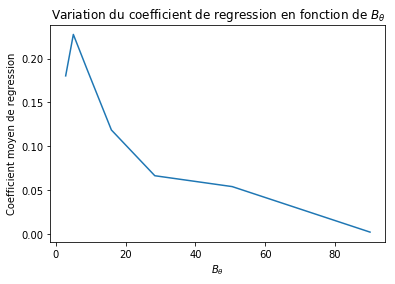

In [21]:
avg_list = []
plt_list = []
for b_theta in b_thetas_list :
    avg_list = []
    for coef in coef_list :
        if coef[0] == b_theta :
            avg_list.append(coef[1])
    plt_list.append(np.mean(avg_list))

plt.plot(b_thetas_list, plt_list)
plt.xlabel(r'$B_\theta$')
plt.ylabel('Coefficient moyen de regression')
plt.title(r'Variation du coefficient de regression en fonction de $B_\theta$')
plt.savefig('./figs/B_theta_curve.pdf',format='pdf', dpi=1000)
plt.show()

# Unused

In [ ]:
plt_expr = expr_fit(hires_b_thetas_list, rnn_f1)
plt_log = log_fit(hires_b_thetas_list, rnn_f1)

plt.plot(hires_b_thetas_list, plt_expr, label = 'expr')
plt.plot(hires_b_thetas_list, plt_log, label = 'log')
plt.plot(hires_b_thetas_list, rnn_f1, 'b.')
plt.title ('RNN fit comparison')
plt.legend()

In [ ]:
plt_expr = expr_fit(b_thetas_list, hum_f1)
plt_log = log_fit(b_thetas_list, hum_f1)

plt.title('Human fit comparison')
plt.plot(b_thetas_list, plt_expr, label = 'expr')
plt.plot(b_thetas_list, plt_log, label = 'log')
plt.plot(b_thetas_list, hum_f1, 'b.')
plt.legend()